In [1]:
# Imports

import paho.mqtt.client as mqtt
import requests
from gym import Env, spaces
import numpy as np
import random
import time
import tensorflow as tf
from statistics import mean
import matplotlib as mpl
import matplotlib.pyplot as plt

from gym.wrappers import FilterObservation, FlattenObservation
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback



In [2]:
# Initilaization

vehicle_speed=0.00
engine_speed=0.00
fuel_consumed=0.00
odometer=0.00
latitude=0.00
longitude=0.00
brake_level=0.00
gear_position='neutral'



MQTT Connection

In [3]:
# MQTT connection

client = mqtt.Client()
message_counter=0
repeatCounter=0
initial_speed=0
initial_reading=0
step_distance=0
stable= False
first = True

def on_connect(client, userdata, flags, rc):
    print("MQTT Client Connected with result code "+str(rc))
    client.subscribe("knowgo/#")
    global message_counter
    message_counter=0


def on_disconnect(client, userdata, rc):
    if rc != 0:
        print("MQTT Client Unexpected disconnection.")
    print("MQTT Client Disconnected")

def on_message(client, userdata, msg):

    msg.payload = msg.payload.decode("utf-8")

    global message_counter
    global repeatCounter
    global initial_speed
    global initial_reading
    global step_distance
    global stable
    global first

    global vehicle_speed
    global engine_speed
    global fuel_consumed
    global odometer
    global latitude
    global longitude
    global brake_level
    global gear_position

    if "vehicle_speed" in msg.topic:
        vehicle_speed = str(msg.payload).strip("b")
        vehicle_speed=int(float(vehicle_speed))

        if first:
            initial_speed = vehicle_speed
        else:
            if(initial_speed==vehicle_speed):
                repeatCounter+=1
                if(repeatCounter==2):
                    StartStopRequest(action='stop')
                    stable = True
            else:
                repeatCounter=0
                initial_speed = vehicle_speed

    elif "engine_speed" in msg.topic:
        engine_speed = str(msg.payload).strip("b")
        engine_speed=float(engine_speed)
        
    elif "fuel_consumed_since_restart" in msg.topic:
         fuel_consumed= float(str(msg.payload).strip("b"))

    elif "odometer" in msg.topic:
        odometer = float(str(msg.payload).strip("b"))
            
    elif "latitude" in msg.topic:
        latitude = float(str(msg.payload).strip("b"))

    elif "longitude" in msg.topic:
        longitude = float(str(msg.payload).strip("b"))

    elif "brake_pedal_position" in msg.topic:
       brake_level = str(msg.payload).strip("b")

    elif "transmission_gear_position" in msg.topic:
        gear_position= str(msg.payload).strip("b")

    elif "timestamp" in msg.topic:
        message_counter+=1
        if first:
            first=False

    
client.on_connect = on_connect
client.on_message = on_message
client.on_disconnect = on_disconnect

def connection_start():
    # client.connect("localhost", 1883, 60)
    client.connect_async("localhost", 1883, 60)
    client.loop_start()
    

def connection_stop():
    client.loop_stop()
    client.disconnect()

REST API requests

In [4]:

def ActionRequest(acceleration,braking,gear):

    api_url = "http://localhost:8086/simulator/events"

    # print("gear value before round",gear)

    gear=round(gear)

    if gear==1:
        gear_value ='first'
    elif gear==2:
        gear_value ='second'
    elif gear == 3:
        gear_value = 'third'
    elif gear == 4:
        gear_value = 'fourth'
    elif gear == 5:
        gear_value = 'fifth'
    elif gear == 6:
        gear_value = 'sixth'

    request_data = [
    {
        "accelerator_pedal_position": float("{:.2f}".format(acceleration)),
        "brake_pedal_position": float("{:.2f}".format(braking)),
        "transmission_gear_position": gear_value
    }
    ]
    # print("step 3 action http request",request_data)
    response = requests.post(api_url, json=request_data)

    if response.status_code == 200:
        return True
    else:
        return False

Starting Stoping the Simulated Vehicle HTTP request

In [5]:
def StartStopRequest(action):
    api_url = "http://localhost:8086/simulator/"+action

    response = requests.post(api_url)

    # print("REST API",action)

    if response.status_code == 200:
        return True
    else:
        return False


In [6]:
def ResetRequest():
    api_url = "http://localhost:8086/simulator/events"

    request_data = [
        {
            "steering_wheel_angle": 0.0,
            "torque_at_transmission": 135.0,
            "engine_speed": 0.0,
            "vehicle_speed": 0.0,
            "accelerator_pedal_position": 10.0,
            "brake_pedal_position": 0.0,
            "transmission_gear_position": "neutral",
            "odometer": 0.0,
            "ignition_status": "run",
            "fuel_level": 99.99,
            "fuel_consumed_since_restart": 0.00,
            "door_status": "all_unlocked",
            "latitude": 48.02025,
            "longitude": 11.58485,
            "bearing": 0.0,
  
        }
     
    ]
    response = requests.post(api_url, json=request_data)

    # print("Response status", response.status_code)

    if response.status_code== 200:
        return True
    else:
        return False


In [7]:
def norm(val, max, min):
    return((val-min)/(max-min))

def denorm(value, max, min):
    return (value*(max-min)+min)


In [8]:
def applyAction(action):

    global message_counter
    global repeatCounter
    global stable
    global first

    message_counter= 0
    repeatCounter=0
    stable=False
    first= True

    acc_action = denorm(action[0],100,0)
    brk_action= denorm(action[1],20,0)
    ger_action=denorm(action[2],6,1)

    # print("step 2 denorm action",acc_action,brk_action,ger_action)

    step_start = time.time_ns()
    Requeststatus = ActionRequest(acc_action, brk_action, ger_action)
    
    # if Requeststatus:
    #     # print("Request Sucessful")

    while stable == False:   # Waiting for the simulater to become stable

        time.sleep(1)
        cuurr = time.time_ns()
        step_check = cuurr-step_start
        if(step_check >= 30000000000 or latitude >= 48.0359):
            stable=True
            StartStopRequest(action='stop')

    step_stop=time.time_ns()
    step_time = (step_stop-step_start)/1000000000
    return vehicle_speed, fuel_consumed, odometer, engine_speed, latitude, longitude, step_time

    

Custom Environment Implementation

In [9]:
class VehicleEnv(Env):

    def __init__(self):

        self.action_space = spaces.Box(
            np.array([0, 0, 0]).astype(np.int32),
            np.array([1, 1, 1]).astype(np.int32),
        )
        
        self.observation_space=spaces.Dict(
            {"vehicle_speed": spaces.Box(low=np.array([0]), high=np.array([200])),
             "fuel_consumed": spaces.Box(low=np.array([0]), high=np.array([100])),
             "distance_travelled": spaces.Box(low=np.array([0]), high=np.array([100])),
             "engine_speed": spaces.Box(low=np.array([0]), high=np.array([5460])),
             "time_taken": spaces.Box(low=np.array([0]), high=np.array([1]))
     
             
            }
        )
        self.step_counter=5

        self.old_reading=0

        self.fuel_reading=0

        self.fueltank_vol=50 

        self.episode_fuel_avg=[]

        self.episode_step_distence=[]

        self.episode_time = []

        self.last_gear=0

        self.last_speed=0

        self.route_endpoint = {
            "lat": 48.0359,
            "lng": 11.5848
        }
        self.route_currentpoint = {
            "lat": 48.0202, #1.75 km
            "lng": 11.5848
        }
        
    def step(self, action):

        StartStopRequest("start")
        time.sleep(2)

        speed,fuel_percentage,odometer_distance,espeed,lat,lng,Steptime=applyAction(action=action)


        if(self.step_counter==5):

            step_dist=odometer_distance
            self.old_reading=odometer_distance

            fuel_value=fuel_percentage
            self.fuel_reading=fuel_percentage

        else:

            step_dist=odometer_distance-self.old_reading
            fuel_value=fuel_percentage-self.fuel_reading

            self.old_reading=odometer_distance
            self.fuel_reading=fuel_percentage

        if(fuel_value > 0):
            fuel_consumed = fuel_value*self.fueltank_vol 
            fuel_avg = step_dist/fuel_consumed
        else:
            fuel_avg=0

        avg_record = fuel_avg

        norm_speed = norm(speed, 200, 0)
        norm_fuel_avg = norm(fuel_avg, 15, 0)
        norm_odometer = norm(step_dist, 2, 0)
        norm_rpm = norm(espeed, 5500, 0)
        norm_time = norm(Steptime, 31, 0)
    

        if(self.step_counter <= 0):

            done = True
            self.episode_fuel_avg.append(fuel_avg)
            self.episode_step_distence.append(step_dist)
            self.episode_time.append(norm_time)

            fuel_avg = mean(self.episode_fuel_avg)
            step_dist = sum(self.episode_step_distence)
            norm_time = mean(self.episode_time)

            if(fuel_percentage!=0):
                episode_avg = odometer_distance/(fuel_percentage*50)
            else:
                episode_avg=0

            if (espeed == 0 or fuel_value == 0 or step_dist == 0):
                reward=-20
            else:

                reward = (8*norm_fuel_avg)-(2*norm_time)-(norm_rpm)

                if(lat >= self.route_endpoint['lat']):

                    reward=reward+100
            
        else:
            done = False
            self.episode_fuel_avg.append(fuel_avg)
            self.episode_step_distence.append(step_dist)
            self.episode_time.append(norm_time)
            episode_avg = fuel_avg

            if (espeed == 0 or fuel_value == 0 or step_dist == 0):
                reward = -20
            else:

                reward = (8*norm_fuel_avg)-(2*norm_time)-(norm_rpm)

        self.step_counter=self.step_counter-1

        # Return step information

        arr = {
            "vehicle_speed": np.array([norm_speed]).astype(np.float32),
            "fuel_consumed": np.array([norm_fuel_avg]).astype(np.float32),
            "distance_travelled": np.array([norm_odometer]).astype(np.float32),
            "engine_speed": np.array([norm_rpm]).astype(np.float32),
            "time_taken": np.array([norm_time]).astype(np.float32)
   
        }

        info = {"Fuel_avg": fuel_avg,
                "step_distance": step_dist, "step_time": norm_time, "episode_fuel_average": episode_avg, "record_avg": avg_record}

        return arr, reward, done, info

    def render(self):
        
        pass

    def reset(self):

        ResetRequest()

        self.step_counter=5

        self.old_reading=0

        self.episode_fuel_avg = []

        self.episode_step_distence = []

        self.episode_time = []

        arr={
            "vehicle_speed": np.array([0]).astype(np.float32),
            "fuel_consumed": np.array([0]).astype(np.float32),
            "distance_travelled": np.array([0]).astype(np.float32),
            "engine_speed": np.array([0]).astype(np.float32),
            "time_taken": np.array([0]).astype(np.float32)
  

        }

        return arr


In [10]:
class TensorboardCallback(BaseCallback):

    """
    Custom callback for plotting additional values in tensorboard.
    """

    def __init__(self, verbose=0):
        super(TensorboardCallback, self).__init__(verbose)

    def _on_step(self) -> bool:
        # Log scalar value (here a random variable)
        value = np.random.random()
        
        locals()

        fuel_average = self.locals['infos'][0]['Fuel_avg']
        step_distance = self.locals['infos'][0]['step_distance']
        step_time = self.locals['infos'][0]['step_time']
        episode_fuel_avg = self.locals['infos'][0]['episode_fuel_average']

        # print("Call FuelAvg/step distance",
        #       fuel_average, step_distance, step_time)

        self.logger.record('fuel Average', fuel_average)
        self.logger.record('Step Distance',step_distance)
        self.logger.record('Step time', step_time)
        self.logger.record('episode fuel average', episode_fuel_avg)

        return True


In [ ]:
connection_start()
env = VehicleEnv()

model = SAC("MultiInputPolicy", env, verbose=1,
            tensorboard_log="./sac_veh_tensorboard/",gamma=0.95)
model.learn(total_timesteps=1000, callback=TensorboardCallback(),
            log_interval=1)
model.save("sac_vehicle-Run12")

connection_stop()





In [ ]:

env = VehicleEnv()
model = SAC.load("sac_vehicle-Run12")
obs = env.reset()

episodes = 10
# MQTT start sensing
avgs=[]
rpms=[]
spds=[]
tms=[]

for episode in range(1, episodes+1):

    connection_start()
    state = env.reset()
    done = False
    obs = env.reset()
    avg_speed=[]
    avg_rpm=[]
    timetkn=[]
    fuel=[]

    score = 0
    start_time = time.time_ns()

    while not done:
        action, _states = model.predict(obs, deterministic=True)
        # print("action", action)
        obs, reward, done, info = env.step(action)
        # print(obs)
        avg_speed.append(denorm((obs.get('vehicle_speed')[0]),200,0))
        avg_rpm.append(denorm((obs.get('engine_speed')[0]),5460,0))
        timetkn.append(denorm((obs.get('time_taken')[0]), 21, 0))
        fuel.append(obs.get('fuel_consumed')[0])
        score += reward
    end_time = time.time_ns()
    mn_sp=mean(avg_speed)
    mn_rpm=mean(avg_rpm)
    total_time=sum(timetkn)
    mn_fuel=mean(fuel)
    avgs.append(info.get("episode_fuel_average"))
    rpms.append(mn_rpm)
    spds.append(mn_sp)
    tms.append(total_time)
    # print('Episode:{} Score:{} time taken:{}'.format(episode, score, end_time-start_time))


    connection_stop()



Plotting results

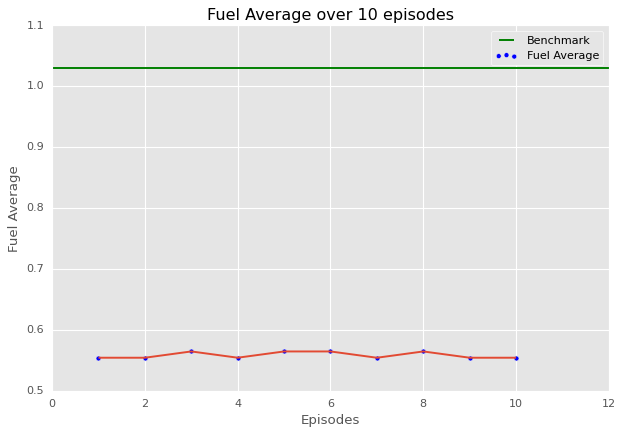

In [116]:
x = np.linspace(1, 10, 10)
plt.style.use('ggplot')
plt.scatter(x, np.array(avgs), label='Fuel Average')
plt.plot(x, np.array(avgs))
plt.axhline(y=1.03, color='g', linestyle='-', label='Benchmark')
plt.xlabel('Episodes')
plt.ylabel('Fuel Average')
plt.title("Fuel Average over 10 episodes")
plt.legend()


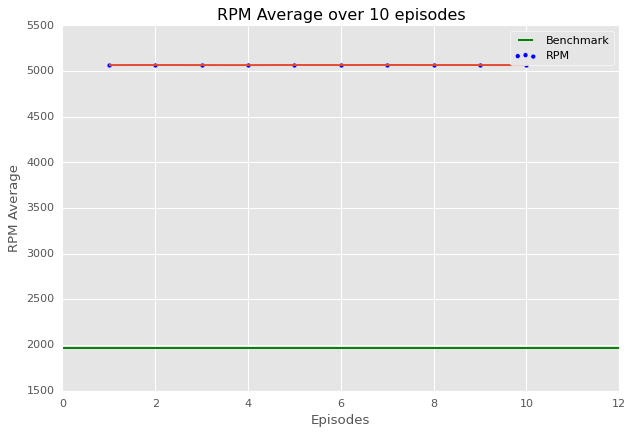

In [117]:
x = np.linspace(1, 10, 10, endpoint=True)
plt.style.use('ggplot')
plt.plot(x, np.array(rpms))
plt.scatter(x, np.array(rpms), label='RPM')
plt.axhline(y=1971, color='g', linestyle='-', label='Benchmark')
plt.xlabel('Episodes')
plt.ylabel('RPM Average')
plt.title("RPM Average over 10 episodes")
plt.legend()


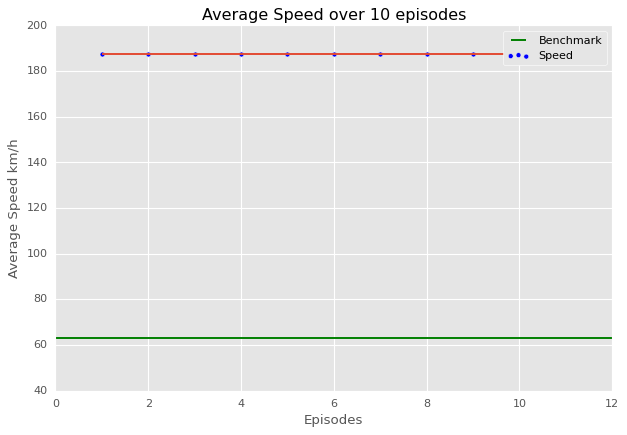

In [118]:
x = np.linspace(1, 10, 10, endpoint=True)
plt.style.use('ggplot')
plt.plot(x, np.array(spds))
plt.scatter(x, np.array(spds), label='Speed')
plt.axhline(y=63, color='g', linestyle='-', label='Benchmark')
plt.xlabel('Episodes')
plt.ylabel('Average Speed km/h')
plt.title("Average Speed over 10 episodes")
plt.legend()


array([44.04, 44.06, 44.03, 44.  , 44.09, 44.08, 44.09, 44.07, 44.05,
       44.02])

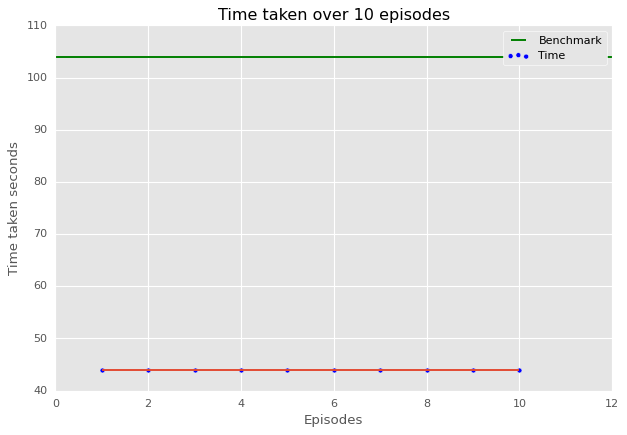

In [119]:
x = np.linspace(1, 10, 10, endpoint=True)
plt.style.use('ggplot')
plt.plot(x,np.round(np.array(tms)))
plt.scatter(x,np.round(np.array(tms)), label='Time')
plt.axhline(y=104, color='g', linestyle='-', label='Benchmark')
plt.xlabel('Episodes')
plt.ylabel('Time taken seconds')
plt.title("Time taken over 10 episodes")
plt.legend()

np.round(tms,2)
